# Classifier
*Written by Viviane Clay*

Classifies objects contained in images taken from the Obstacle Tower environment.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import cv2
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.layers as c_layers
import glob
from scipy import misc
from keras.preprocessing.image import ImageDataGenerator

c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:5

### Data Loading
(Adapt file paths as needed)

Training data can be found here: http://dx.doi.org/10.17632/zdh4d5ws2z.2

In [2]:
all_classes = ['[0, 0, 0, 0]','[0, 0, 0, 1]','[0, 0, 1, 0]','[0, 1, 0, 0]','[0, 1, 1, 0]','[1, 0, 0, 0]',
               '[1, 0, 1, 0]','[2, 0, 0, 0]','[2, 0, 0, 1]','[2, 0, 1, 0]','[2, 1, 0, 0]',#'[2, 1, 1, 0]','[2,0,1,1]'
               '[3, 0, 0, 0]','[3, 0, 0, 1]','[3, 0, 1, 0]','[3, 1, 0, 0]','[4, 0, 0, 0]','[4, 0, 0, 1]',
               '[4, 0, 1, 0]']
datagen = ImageDataGenerator(validation_split=0.1,rescale=1./255)
train_it = datagen.flow_from_directory('./Results/TowerTraining/Classifier/Sorted/', class_mode='sparse',
                                       batch_size=256,shuffle=True,subset="training",target_size=(168,168),classes=all_classes)
val_it = datagen.flow_from_directory('./Results/TowerTraining/Classifier/Sorted/', class_mode='sparse',
                                       batch_size=256,shuffle=True,subset="validation",target_size=(168,168),classes=all_classes)

realLabel = []
for c,v in train_it.class_indices.items():
    c_ext = np.fromstring(c[1:-1], dtype=int, sep=', ')
    realLabel.append(c_ext)

def getRealLabel(labelBatch,RL):
    newLB = []
    for label in labelBatch:
        l = RL[int(label)]
        newLB.append(l)
    return newLB

Found 34990 images belonging to 18 classes.
Found 3879 images belonging to 18 classes.


In [35]:
xVal,yVal = val_it.next()

In [65]:
yVal_r = getRealLabel(yVal,realLabel)

In [2]:
def getFlatLabel(label2D):
    flatLabels = []
    for label in label2D:
        flatLabel = np.zeros(8)
        if label[0] == 0:
            flatLabel[0] = 1
        elif label[0] == 1:
            flatLabel[1] = 1
        elif label[0] == 2:
            flatLabel[2] = 1
        elif label[0] == 3:
            flatLabel[3] = 1
        elif label[0] == 4:
            flatLabel[4] = 1
        if label[1] == 1:
            flatLabel[5] = 1
        if label[2] == 1:
            flatLabel[6] = 1
        if label[3] == 1:
            flatLabel[7] = 1
        flatLabels.append(flatLabel)
    return flatLabels

In [66]:
print(yVal[0])
print(yVal_r[0])
print(getFlatLabel(yVal_r)[0])

15.0
[4 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0.]


### Calculate Class Weights

In [4]:
num_exp = [[0,0,0,0,0],[0,0],[0,0],[0,0]]
classes = [[[0,1,2,3,4],[5,6],[7,8,9,10],[11,12,13,14],[15,16,17]],[[0,1,2,5,6,7,8,9,11,12,13,15,16,17],[3,4,10,14]],
           [[0,1,3,5,7,8,10,11,12,14,15,16],[2,4,6,9,13,17]],[[0,2,3,4,5,6,7,9,10,11,13,14,15,17],[1,8,12,16]]]
for branch in range(len(num_exp)):
    for c in range(len(num_exp[branch])):
        sum_exp = 0
        for s in classes[branch][c]:
            sum_exp = sum_exp + train_it.classes[train_it.classes==s].shape[0]
        num_exp[branch][c] = sum_exp
print('Number of samples: '+str(num_exp))
if np.sum(num_exp[0])== np.sum(num_exp[1]) == np.sum(num_exp[2]) == np.sum(num_exp[3]):
    print('all good')

Number of samples: [[14656, 1426, 12153, 3892, 2863], [32770, 2220], [32277, 2713], [33195, 1795]]
all good


In [5]:
num_exp_new = [[np.sum(num_exp[0])-num_exp[0][0],num_exp[0][0]],
              [np.sum(num_exp[0])-num_exp[0][1],num_exp[0][1]],
              [np.sum(num_exp[0])-num_exp[0][2],num_exp[0][2]],
              [np.sum(num_exp[0])-num_exp[0][3],num_exp[0][3]],
              [np.sum(num_exp[0])-num_exp[0][4],num_exp[0][4]],
              [num_exp[1][0],num_exp[1][1]],
              [num_exp[2][0],num_exp[2][1]],
              [num_exp[3][0],num_exp[3][1]],]

num_exp_new

[[20334, 14656],
 [33564, 1426],
 [22837, 12153],
 [31098, 3892],
 [32127, 2863],
 [32770, 2220],
 [32277, 2713],
 [33195, 1795]]

In [7]:
flat_weights = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
print('Class Weights: ')
for branch in range(8):
    bincount = np.array(num_exp_new[branch])
    weights = np.sum(bincount) / (bincount.shape[0] * bincount)
    flat_weights[branch] = weights
    print(np.round(weights,2))
flat_weights = np.array(flat_weights)

Class Weights: 
[0.86 1.19]
[ 0.52 12.27]
[0.77 1.44]
[0.56 4.5 ]
[0.54 6.11]
[0.53 7.88]
[0.54 6.45]
[0.53 9.75]


In [8]:
NExp = np.sum(num_exp[0])

In [9]:
train_it.class_indices.items()

dict_items([('[0, 0, 0, 0]', 0), ('[0, 0, 0, 1]', 1), ('[0, 0, 1, 0]', 2), ('[0, 1, 0, 0]', 3), ('[0, 1, 1, 0]', 4), ('[1, 0, 0, 0]', 5), ('[1, 0, 1, 0]', 6), ('[2, 0, 0, 0]', 7), ('[2, 0, 0, 1]', 8), ('[2, 0, 1, 0]', 9), ('[2, 1, 0, 0]', 10), ('[3, 0, 0, 0]', 11), ('[3, 0, 0, 1]', 12), ('[3, 0, 1, 0]', 13), ('[3, 1, 0, 0]', 14), ('[4, 0, 0, 0]', 15), ('[4, 0, 0, 1]', 16), ('[4, 0, 1, 0]', 17)])

### Gini Index Calculation

In [10]:
'''@misc{guest2017gini,
  author = "Olivia Guest",
  title = "Using the Gini Coefficient to Evaluate Deep Neural Network Layer Representations",
  year = "2017",
  howpublished = "Blog post",
  url = "http://neuroplausible.com/gini"
}'''
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    #array = np.abs(array)# change from original code
    #if np.amin(array) < 0:
     #   array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient


### Load Test Data (optional)

In [11]:
path = "./Results/TowerTraining/Recordings/Standard/3999_16.100/"
obs = np.load(path+"visobs.npy")
hand_l = pd.read_csv(path+'HandLabels.csv')
label_test = np.zeros(obs.shape[0])
label_test = np.array(hand_l['Label'])
def addLabel(currL,ToAdd):
    if ToAdd<=1:
        return currL
    elif ToAdd==2:
        currL[0] = 4
    elif ToAdd==3:
        currL[0] = 2
    elif ToAdd==4:
        currL[0] = 3
    elif ToAdd==5:
        currL[0] = 4
    elif ToAdd==6:
        currL[0]=1
    elif ToAdd==7:
        currL[1]=1
    elif ToAdd==8:
        currL[2]=1
    elif ToAdd==9:
        currL[3]=1
    else:
        print(ToAdd)
    return currL

def formatLabels(labels1,labels2):
    formatted = []
    for i,l in enumerate(labels1):
        newLabel=[0,0,0,0]
        if l == 0:
            print(i)
        newLabel = addLabel(newLabel,l)
        #print(str(i)+': '+str(newLabel)+ '  '+str(l))
        newLabel = addLabel(newLabel,labels2[i])
        #print(str(i)+': '+str(newLabel)+ '  '+str(labels2[i]))
        formatted.append(newLabel)
    return np.array(formatted)

fLabels = formatLabels(np.array(hand_l['Label']),np.array(hand_l['Secondary label']))

## Object Classification
### Network

In [37]:
tf.reset_default_graph()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

o_size_h = 168
o_size_w = 168
num_layers = 2
h_size = 256
h_size_vec = 256
            
visual_in = tf.placeholder(shape=[None, o_size_h, o_size_w, 3], dtype=tf.float32,name="visual_observation_0")
labels = tf.placeholder(shape=[None,8], dtype=tf.int64,name="labels")

def create_vector_observation_encoder(observation_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        hidden_vec = observation_input
        for i in range(num_layers):
            hidden_vec = tf.layers.dense(hidden_vec, h_size, activation=activation, reuse=reuse,name="hidden_{}".format(i),kernel_initializer=c_layers.variance_scaling_initializer(1.0))
    return hidden_vec

def create_visual_observation_encoder(image_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        conv1 = tf.layers.conv2d(image_input, 16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, reuse=reuse, name="conv_1")
        conv2 = tf.layers.conv2d(conv1, 32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, reuse=reuse, name="conv_2")
        hidden_vis = c_layers.flatten(conv2)

    with tf.variable_scope(scope + '/' + 'flat_encoding'):
        hidden_flat = create_vector_observation_encoder(hidden_vis, h_size, activation,num_layers, scope, reuse)
    return hidden_flat

visual_encoders = []

encoded_visual = create_visual_observation_encoder(visual_in,h_size,swish,num_layers,"main_graph_0_encoder0", False)
visual_encoders.append(encoded_visual)
hidden = tf.concat(visual_encoders, axis=1)

out_acts = []
for o in range(8):
    out_acts.append(tf.layers.dense(hidden, 2, activation=tf.nn.softmax, use_bias=False,kernel_initializer=c_layers.variance_scaling_initializer(factor=0.01)))
print(out_acts)

output = tf.concat([tf.multinomial(tf.log(out_acts[k]), 1) for k in range(8)], axis=1)#sample outputs from log probdist
print(output)

comparison = tf.equal(labels, output)

accuracy = tf.reduce_mean(tf.cast(comparison, dtype=tf.float32))

class_weights = tf.constant(flat_weights,dtype='float32')
print(class_weights)

cross_entropies = []
weighted_cross_entropies = []
for c in range(8):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = out_acts[c], labels = labels[:,c])
    print(cross_entropy)
    cross_entropies.append(cross_entropy)
    weights = tf.reduce_sum(class_weights[c] * tf.one_hot(labels[:,c],2), axis=1)
    print('weights')
    print(weights)
    scaled_error = cross_entropy * weights
    weighted_cross_entropies.append(scaled_error)

print(cross_entropies)
print(weighted_cross_entropies)

mean_cross_entropy = tf.reduce_mean(weighted_cross_entropies)
print(mean_cross_entropy)

optimizer = tf.train.AdamOptimizer(0.0001)

gradients = optimizer.compute_gradients(mean_cross_entropy)
hidden_grad = tf.gradients(mean_cross_entropy,hidden)

training_step = optimizer.minimize(mean_cross_entropy)

saver = tf.train.Saver()

[<tf.Tensor 'dense/Softmax:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'dense_1/Softmax:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'dense_2/Softmax:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'dense_3/Softmax:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'dense_4/Softmax:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'dense_5/Softmax:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'dense_6/Softmax:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'dense_7/Softmax:0' shape=(?, 2) dtype=float32>]
Tensor("concat_1:0", shape=(?, 8), dtype=int64)
Tensor("Const_1:0", shape=(8, 2), dtype=float32)
Tensor("SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)
weights
Tensor("Sum:0", shape=(?,), dtype=float32)
Tensor("SparseSoftmaxCrossEntropyWithLogits_1/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)
weights
Tensor("Sum_1:0", shape=(?,), dtype=float32)
Tensor("SparseSoftmaxCrossEntropyWithLogits_2/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,)

In [30]:
def getOutStats(out,fL):
    c = plt.hist(np.array(out)+np.array(fL)/2, bins = [0,0.5,1,1.5,2])
    precision = np.round(np.array(c[0])[:,3]/(np.array(c[0])[:,3]+np.array(c[0])[:,2])*100,2)# If L is predicted it is correct X% of time
    recall = np.round(np.array(c[0])[:,3]/(np.array(c[0])[:,3]+np.array(c[0])[:,1])*100,2)# Correctly identifies X% of L
    f1score = np.round(2*(precision*recall/(precision+recall)),2)
    return precision, recall, f1score

### Train Classifier

            Entropy    Accuracy
epoch 0 sample output: [1 1 1 1 0 0 0 0]
[46.41  6.49 45.95 20.61  9.93 12.41 17.11  7.25]
Validation:  0.6765748 - 0.4970703
Test:  0.80026966 - 0.49996874 - Gini: 0.434
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]


c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


epoch 1 sample output: [1 1 1 0 0 1 1 1]
[63.24 11.33 40.   15.27 28.31  9.16 14.2  12.31]
Training: 0.6028093 - 0.55078125    Validation:  0.6320245 - 0.58203125
Test:  0.73901474 - 0.5715625 - Gini: 0.525
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
saved model
epoch 2 sample output: [1 0 0 0 0 1 0 0]
[67.02  6.97 43.4  31.33 26.86 13.85  8.33 17.39]
Training: 0.5904514 - 0.66015625    Validation:  0.65629196 - 0.6347656
Test:  0.6952178 - 0.62653124 - Gini: 0.501
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
saved model
epoch 3 sample output: [0 0 0 1 1 1 1 1]
[70.43 35.3  51.14 31.58 38.53 22.82 13.53 18.19]
Training: 0.5454902 - 0.6899414    Validation:  0.5933485 - 0.67285156
Test:  0.64953625 - 0.64821875 - Gini: 0.491

c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Test:  0.6330647 - 0.7172812 - Gini: 0.499
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
saved model
epoch 5 sample output: [0 0 1 0 0 1 1 0]
[70.05 35.89 54.16 43.25 55.7  15.88 18.18 42.86]
Training: 0.5256431 - 0.7636719    Validation:  0.5006032 - 0.7685547
Test:  0.6343869 - 0.72175 - Gini: 0.503
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
saved model
epoch 6 sample output: [1 0 0 0 1 0 1 0]
[73.49 41.38 59.69 32.78 35.79 20.51 31.7  23.15]
Training: 0.5072137 - 0.77734375    Validation:  0.50143373 - 0.7480469
Test:  0.60996777 - 0.7156875 - Gini: 0.515
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.

Test:  0.6255027 - 0.8422812 - Gini: 0.561
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 26 sample output: [1 0 0 0 0 0 0 0]
[82.73 66.67 69.61 65.67 72.22 48.65 48.98 37.21]
Training: 0.3633265 - 0.94384766    Validation:  0.45516568 - 0.9003906
Test:  0.6052557 - 0.84534377 - Gini: 0.56
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 27 sample output: [0 0 1 0 0 0 0 0]
[83.84 60.87 79.41 53.85 73.34 50.   54.54 68.75]
Training: 0.3616319 - 0.9555664    Validation:  0.4711039 - 0.9135742
Test:  0.6438743 - 0.843 - Gini: 0.562
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
saved model
epo

precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
saved model
epoch 47 sample output: [1 0 0 0 0 0 0 0]
[80.89 86.96 71.17 70.   81.08 70.27 69.57 91.89]
Training: 0.3464285 - 0.9794922    Validation:  0.44995677 - 0.92871094
Test:  0.665886 - 0.8693125 - Gini: 0.559
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 48 sample output: [0 0 1 1 0 0 0 0]
[83.41 66.67 75.   70.   80.   43.48 53.85 76.93]
Training: 0.34324098 - 0.9873047    Validation:  0.48815557 - 0.92333984
Test:  0.6627661 - 0.87075 - Gini: 0.554
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 49 sample output: [1 0 0 0 0 0 0 0]


epoch 68 sample output: [0 0 0 0 1 0 0 0]
[ 90.91 100.    80.    75.    87.5     nan    nan 100.  ]
Training: 0.33431193 - 0.9892578    Validation:  0.45182633 - 0.94871795
Test:  0.663584 - 0.87834376 - Gini: 0.559
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
saved model
epoch 69 sample output: [0 0 1 0 0 0 0 0]
[84.85 85.71 85.4  77.61 88.89 55.56 56.41 66.67]
Training: 0.3256663 - 0.9892578    Validation:  0.4662827 - 0.94433594
Test:  0.66996837 - 0.8755 - Gini: 0.557
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 70 sample output: [1 0 0 0 0 0 0 0]
[87.03 80.   77.22 69.84 86.96 63.63 62.86 92.31]
Training: 0.33308563 - 0.9873047    Validation:  0.43755114 - 0.9433594
Test:  0.661474 - 0.8765625 - Gini: 0.559
precis

Test:  0.66955435 - 0.875625 - Gini: 0.574
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 90 sample output: [1 0 0 0 0 0 0 0]
[85.19 58.83 81.56 69.57 82.92 42.85 73.17 58.82]
Training: 0.318475 - 0.9897461    Validation:  0.4702665 - 0.9345703
Test:  0.6607661 - 0.87296873 - Gini: 0.586
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 91 sample output: [0 0 1 0 0 0 1 0]
[82.24 89.66 78.61 64.71 71.43 62.07 66.67 92.86]
Training: 0.33746406 - 0.98828125    Validation:  0.437048 - 0.9321289
Test:  0.6644674 - 0.8661562 - Gini: 0.593
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 92 sam

epoch 111 sample output: [1 0 0 0 0 0 0 0]
[78.9  72.73 81.51 75.   84.85 63.63 59.57 78.26]
Training: 0.31194252 - 0.9897461    Validation:  0.41789794 - 0.93310547
Test:  0.6627416 - 0.8726562 - Gini: 0.607
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 112 sample output: [1 0 0 0 0 0 1 0]
[85.71 66.67 78.11 74.19 76.19 58.07 55.81 71.79]
Training: 0.36267722 - 0.9848633    Validation:  0.49753737 - 0.9301758
Test:  0.6467595 - 0.87478125 - Gini: 0.608
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 113 sample output: [1 0 0 0 0 0 0 0]
[82.45 76.92 77.49 65.3  80.   52.94 44.45 57.14]
Training: 0.33272827 - 0.99365234    Validation:  0.48355693 - 0.92626953
Test:  0.65748614 - 0.8799375 - Gini: 0.604
precision: [87.

Test:  0.6646267 - 0.87609375 - Gini: 0.601
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 133 sample output: [1 0 0 0 0 0 0 0]
[92.59 46.15 86.21 77.97 80.95 70.   42.86 69.57]
Training: 0.33832282 - 0.9941406    Validation:  0.47701824 - 0.94873047
Test:  0.6642234 - 0.8790625 - Gini: 0.596
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 134 sample output: [1 0 0 0 0 0 0 0]
[86.18 73.69 77.84 61.54 81.82 44.44 81.08 77.78]
Training: 0.31151438 - 0.9975586    Validation:  0.44224826 - 0.94140625
Test:  0.6652954 - 0.88075 - Gini: 0.594
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 

epoch 154 sample output: [1 0 0 0 0 0 0 0]
[86.88 60.   79.38 73.02 87.5  45.45 56.25 85.71]
Training: 0.33943045 - 0.99121094    Validation:  0.44490552 - 0.93896484
Test:  0.6578149 - 0.8842813 - Gini: 0.604
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 155 sample output: [1 0 0 0 0 0 0 0]
[83.93 63.15 75.29 67.74 84.85 51.62 46.51 80.  ]
Training: 0.36069015 - 0.98779297    Validation:  0.54080284 - 0.92578125
Test:  0.6574226 - 0.88440627 - Gini: 0.603
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 156 sample output: [0 0 0 0 1 0 0 1]
[84.06 69.56 77.71 77.92 76.19 43.48 65.12 87.5 ]
Training: 0.3612246 - 0.9892578    Validation:  0.48285857 - 0.9355469
Test:  0.6635995 - 0.88284373 - Gini: 0.602
precision: [87.

Test:  0.65518785 - 0.88421875 - Gini: 0.611
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 176 sample output: [1 0 0 0 0 0 0 0]
[87.56 53.33 81.53 82.19 84.44 38.09 57.78 86.96]
Training: 0.34372234 - 0.99072266    Validation:  0.49149555 - 0.9423828
Test:  0.6543821 - 0.8861875 - Gini: 0.612
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 177 sample output: [1 0 0 0 0 0 0 0]
[85.71 66.67 76.02 73.68 79.17 33.33 54.55 83.33]
Training: 0.3302979 - 0.9946289    Validation:  0.51771307 - 0.93359375
Test:  0.65963095 - 0.8845937 - Gini: 0.611
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epo

epoch 197 sample output: [1 0 0 0 0 0 0 0]
[89.81 90.91 83.51 69.09 80.   57.14 62.22 73.33]
Training: 0.3462968 - 0.99316406    Validation:  0.44178948 - 0.94433594
Test:  0.6638685 - 0.8801875 - Gini: 0.618
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 198 sample output: [0 0 1 0 0 0 0 0]
[85.98 60.   81.08 83.08 90.91 76.93 68.29 76.19]
Training: 0.33489662 - 0.99365234    Validation:  0.4182994 - 0.9472656
Test:  0.6579585 - 0.88215625 - Gini: 0.619
precision: [87.01 80.98 44.03 37.92 56.14  0.   52.23 73.66]
recall: [68.55 81.42 56.4  39.95 71.74  0.   59.21 55.68]
f1score: [76.68 81.2  49.45 38.91 62.99   nan 55.5  63.42]
epoch 199 sample output: [0 0 0 1 0 0 0 0]
[86.41 94.74 80.23 80.   78.95 34.78 71.43 82.35]
Training: 0.3217107 - 0.9970703    Validation:  0.47549716 - 0.94433594
Test:  0.6585673 - 0.88403124 - Gini: 0.617
precision: [87.01

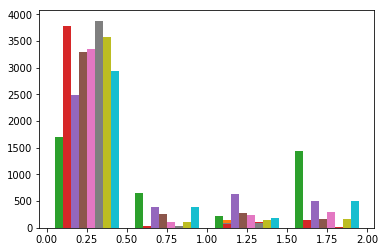

In [38]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Allentropies = []
Allaccuracies = []
Allscaled_errs = []
AllValaccuracies = []
AllGinis = []
LastSave = 0
fL = getFlatLabel(fLabels)

print('            Entropy    Accuracy')
epochs = 200
for i in range(epochs):
    count = 0
    xVal,yVal = val_it.next()
    yVal = getRealLabel(yVal,realLabel)
    yVal = getFlatLabel(yVal)
    w,Valentro,ValentroD, ValWEntro,Valaccu,Valcomp,Valout = sess.run([weights,mean_cross_entropy,cross_entropies,weighted_cross_entropies,accuracy, comparison,output], feed_dict = {visual_in: xVal, labels: yVal})
    print('epoch ' + str(i) + ' sample output: ' + str(Valout[0]))
    p,r,valf1 = getOutStats(Valout,yVal)
    print(valf1)
    if i==0:
        print('Validation:  '+str(Valentro)+ ' - '+str(Valaccu))
        AllValaccuracies.append(Valaccu)
    else:
        print('Training: '+str(np.mean(entropies))+' - '+str(np.mean(accuracies))+
          '    Validation:  '+str(Valentro)+ ' - '+str(Valaccu))
    
    Testentro, Testaccu,TestEnc = sess.run([mean_cross_entropy, accuracy, encoded_visual], feed_dict = {visual_in: obs, labels: fL})
    print('Test:  '+str(Testentro)+ ' - '+str(Testaccu)+ ' - Gini: ' + str(np.round(gini(np.abs(TestEnc)),3)))
    AllGinis.append(gini(np.abs(TestEnc)))
    p,r,f1 = getOutStats(out,fL)
    print('precision: '+str(p))
    print('recall: '+str(r))
    print('f1score: '+str(f1))
    
    if Valaccu > np.max(AllValaccuracies):
        saver.save(sess, "./Results/TowerTraining/Classifier/Model_flat_weighted/model.ckpt")
        print('saved model')
        LastSave = i-1
        
    AllValaccuracies.append(Valaccu)
    for batchX, batchy in train_it:
        batchy = getRealLabel(batchy,realLabel)
        batchy = getFlatLabel(batchy)
        entropies = []
        accuracies = []
        entro, all_entro,accu,comp, _ = sess.run([mean_cross_entropy, weighted_cross_entropies,accuracy, comparison,training_step], feed_dict = {visual_in: batchX, labels: batchy})
        entropies.append(entro)
        accuracies.append(accu)
        if count>126:
            Allentropies.append(entropies)
            Allaccuracies.append(accuracies)
            break
        count = count+1

## Results
### Plot Training Statistics

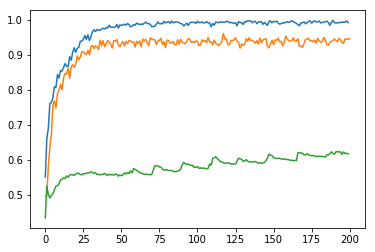

In [40]:
plt.plot(Allaccuracies)
plt.plot(AllValaccuracies)
plt.plot(AllGinis)

### Save

In [41]:
np.save("./Results/TowerTraining/Classifier/Model_flat_weighted_2/Accs.npy",Allaccuracies)
np.save("./Results/TowerTraining/Classifier/Model_flat_weighted_2/Entro.npy",Allentropies)
np.save("./Results/TowerTraining/Classifier/Model_flat_weighted_2/Err.npy",Allscaled_errs)
np.save("./Results/TowerTraining/Classifier/Model_flat_weighted_2/ValAcc.npy",AllValaccuracies)
np.save("./Results/TowerTraining/Classifier/Model_flat_weighted_2/Ginis.npy",AllGinis)

### Test on Test Run Observations

In [14]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver.restore(sess, "./Results/TowerTraining/Classifier/Model_flat_weighted/model.ckpt")
act,out,grad,HG = sess.run([hidden,output,gradients,hidden_grad], feed_dict = {visual_in: obs,labels: getFlatLabel(fLabels)})

INFO:tensorflow:Restoring parameters from ./Results/TowerTraining/Classifier/Model_flat_weighted/model.ckpt


In [4]:
accs = np.load("./Results/TowerTraining/Classifier/Model_flat_weighted/ValAcc.npy")

In [15]:
print('After Training: '+str(np.sum(out==getFlatLabel(fLabels))/(4000*8)*100))

After Training: 88.128125


In [17]:
fL = getFlatLabel(fLabels)

c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


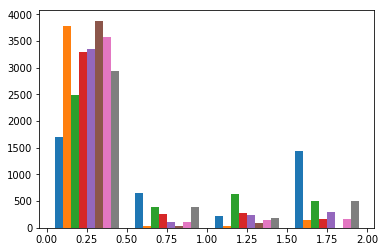

In [18]:
c = plt.hist(np.array(out)+np.array(fL)/2, bins = [0,0.5,1,1.5,2])
precision = np.round(np.array(c[0])[:,3]/(np.array(c[0])[:,3]+np.array(c[0])[:,2])*100,2)# If L is predicted it is correct X% of time
recall = np.round(np.array(c[0])[:,3]/(np.array(c[0])[:,3]+np.array(c[0])[:,1])*100,2)# Correctly identifies X% of L
f1score = np.round(2*(precision*recall/(precision+recall)),2)

In [22]:
figurePath = './Results/TowerTraining/Figures/AgentRewardComparisonsAdaTH/ActivationPatternsNormx2No-01/'
classifier_stats = np.load(figurePath+'classifier_stats.npy',allow_pickle='TRUE').item()

In [23]:
classifier_stats

{'Accuracy': 82.09876543209876,
 'Accuracies': array([87.407, 94.296, 86.148, 86.444, 93.259, 82.37 , 90.148]),
 'Precisions': array([76.012, 88.106, 59.347, 65.581, 85.333, 56.977, 78.261]),
 'Recalls': array([75.143, 80.   , 80.   , 56.4  , 76.8  , 19.6  , 64.8  ]),
 'F1Scores': array([75.58, 83.86, 68.14, 60.64, 80.84, 29.17, 70.9 ])}

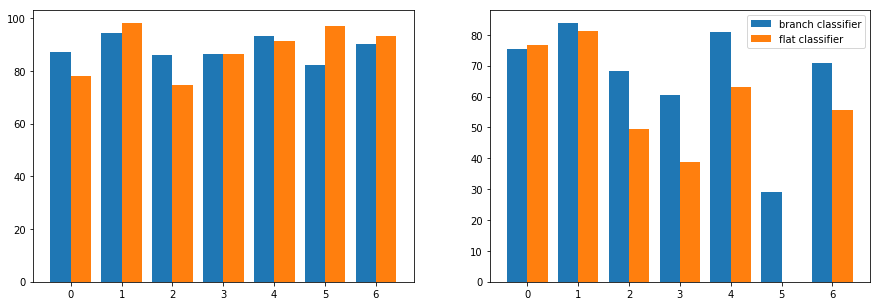

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(np.linspace(-0.2,5.8,7),classifier_stats['Accuracies'],width=0.4)
plt.bar(np.linspace(0.2,6.2,7),cflat_stats[:-1],width=0.4)
plt.subplot(1,2,2)
plt.bar(np.linspace(-0.2,5.8,7),classifier_stats['F1Scores'],width=0.4)
plt.bar(np.linspace(0.2,6.2,7),f1score[:-1],width=0.4)
plt.legend(['branch classifier','flat classifier'])
plt.show()